In [12]:
## import dependencies 
import tensorflow as tf
import numpy as np 
import pandas as pd 
from datetime import datetime, date, time
import os 
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
## importing dependencies 
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS 

## define influxdb paramters
token = "A1hvR7pmPINW66Wuxbb7dpwR74TukBJIC7IuP3ADhr4xTx0Zzx-JZxzgInUUFbikMsg_bNo2TI4QnbXnUIOkDg=="
org = "ThirdYearProject"
bucket = "de75cd94d8127ada"

## connect to influxdb
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)

In [14]:
## query data

query_api = client.query_api()

query_train = 'from(bucket:"MicrosoftData")\
|> range(start:  2015-01-01T00:00:00Z, stop: 2016-05-01T11:59:59Z)\
|> filter(fn: (r) => r._measurement == "Network Prediction"\
and r.Channel == "channel_1142" and r.Segment == "31")\
|> pivot(rowKey:["_time"], columnKey:["_field"], valueColumn:"_value")\
|> keep(columns: ["_time", "Q-Factor"])' # may need to add in specific channel 
#|> aggregateWindow(every:1h, fn:mean,createEmpty:false)

query_test = 'from(bucket:"MicrosoftData")\
|> range(start:  2015-01-01T00:00:00Z, stop: 2016-05-01T11:59:59Z)\
|> filter(fn: (r) => r._measurement == "Network Prediction"\
and r.Channel == "channel_1303" and r.Segment == "34")\
|> pivot(rowKey:["_time"], columnKey:["_field"], valueColumn:"_value")\
|> keep(columns: ["_time", "Q-Factor"])'

data_train = query_api.query_data_frame(query_train)
data_train = query_api.query_data_frame(query_test)
data.set_index("_time", inplace=True)
data.index = pd.to_datetime(data.index)
data.drop('result', axis=1, inplace=True)
data.drop('table', axis=1, inplace=True)
data.head()

,Q-Factor
_time,
2015-02-02 12:00:00+00:00,12.29
2015-02-02 12:15:00+00:00,12.29
2015-02-02 12:30:00+00:00,12.26
2015-02-02 12:45:00+00:00,12.24
2015-02-02 13:00:00+00:00,12.33


In [15]:
#checking for erroneous data
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Q-Factor,35074.0,13.118364,0.509165,10.44,13.05,13.34,13.49,13.85


In [16]:
# connected graph
#plot_cols=["Q-Factor"]
#plot_features=data[plot_cols]
#plot_features.index=data.index
#_=plot_features.plot(subplots=True, ylabel="Polarization Mode Dispersion (ps)", xlabel="February (days)")

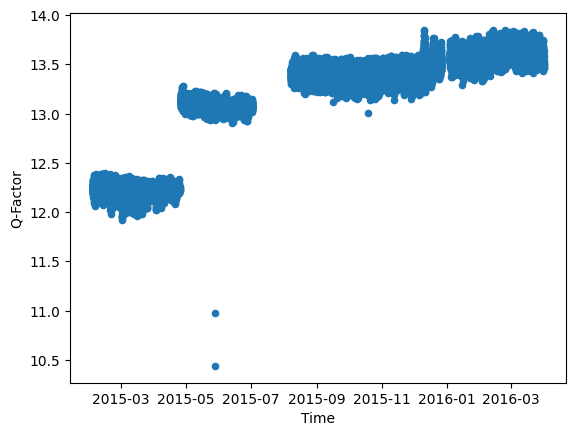

In [17]:
plt.scatter(data.index, data['Q-Factor'],s=20)
plt.xlabel('Time')
plt.ylabel('Q-Factor')
plt.show()

In [18]:
## converting data to numpy for better/faster processing 
time_index = np.array(data.index)
data = np.array(data['Q-Factor'])

In [19]:
## train-test-validation split 
n=len(data)
train_data = data[:int(n*0.7)]
train_time = time_index[:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
val_time = time_index[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.7):]
test_time = time_index[int(n*0.7):]

In [20]:
# finding mean and standard deviation in order to normalise data
# should really be done using moving average
#train_mean = train_data.mean()
#train_std = train_data.std()

# normalising 
#train_data = (train_data - train_mean)/train_std
#val_data = (val_data - train_mean)/train_std
#test_data = (test_data - train_mean)/train_std

# examining distribution features
#data_std = (data - train_mean) / train_std
#data_std = data_std.melt(var_name='Column', value_name='Normalized')
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=data_std)
#_ = ax.set_xticklabels(data.keys(), rotation=90)

In [21]:
## required parameters

WINDOW_SIZE = 360
BATCH_SIZE = 32
SHUFFLE_BUFFER = 35000

## function to create input features
# data converted -> TensorFlow dataset
# window function called, to create different input features
# flat_map to preserve order of time series by flattening data 
# shuffle and create batches of data for training a DL model

def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size+1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data #expanding data into tensors 

tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)
tensor_val_data = tf.expand_dims(val_data, axis=-1)

# generating input and output features for training and testing set 
tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_val_dataset = ts_data_generator(tensor_val_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [23]:
# building model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu",
        input_shape=[None,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
 
    tf.keras.layers.LSTM(64, return_sequences=True), 
 
    tf.keras.layers.Dense(30, activation="relu"),  
 
    tf.keras.layers.Dense(10, activation="relu"), 
 
    tf.keras.layers.Dense(1)])
    #tf.keras.layers.Lambda(input_shape=[WINDOW_SIZE]),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    #tf.keras.layers.Dense(1),
    #tf.keras.layers.Lambda(lambda x: x * 100.0)
    #tf.keras.layers.Dense(10, input_shape=[WINDOW_SIZE], activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    #tf.keras.layers.Dense(1)
##])

# optimiser algorithm adjust weights of network's neurons and learning rate
# reduces loss and improves overall accuracy
optimiser = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiser, metrics=["mae"])
history = model.fit(tensor_train_dataset, epochs=10, validation_data=tensor_val_dataset)

Epoch 1/10
756/756 [==============================] - 268s 335ms/step - loss: 0.8219 - mae: 1.1465 - val_loss: 0.1681 - val_mae: 0.5232
Epoch 2/10
756/756 [==============================] - 239s 304ms/step - loss: 0.1277 - mae: 0.4004 - val_loss: 0.2272 - val_mae: 0.6488
Epoch 3/10
756/756 [==============================] - 245s 314ms/step - loss: 0.0751 - mae: 0.2602 - val_loss: 0.0361 - val_mae: 0.1552
Epoch 4/10
756/756 [==============================] - 241s 306ms/step - loss: 0.0294 - mae: 0.1263 - val_loss: 0.0218 - val_mae: 0.0939
Epoch 5/10
756/756 [==============================] - 245s 313ms/step - loss: 0.0227 - mae: 0.1087 - val_loss: 0.0172 - val_mae: 0.0854
Epoch 6/10
756/756 [==============================] - 247s 314ms/step - loss: 0.0190 - mae: 0.1005 - val_loss: 0.0161 - val_mae: 0.0917
Epoch 7/10
756/756 [==============================] - 243s 311ms/step - loss: 0.0173 - mae: 0.0983 - val_loss: 0.0131 - val_mae: 0.0787
Epoch 8/10
756/756 [============================

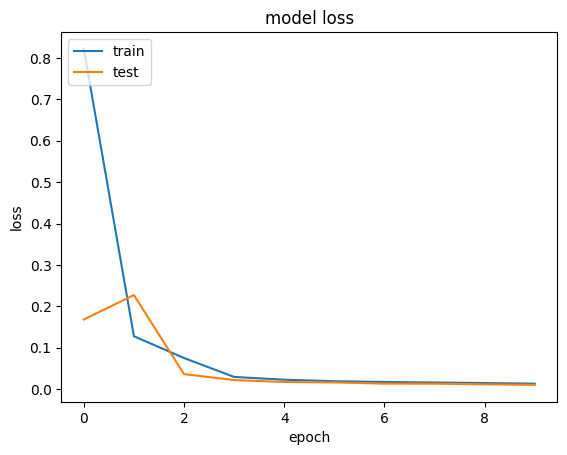

In [24]:
## losses of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
## making a prediction
def model_forecast(model, data, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(model, data[...,np.newaxis], WINDOW_SIZE, BATCH_SIZE)
forecast = forecast[int(n*0.7) - WINDOW_SIZE:-1, -1]

error = tf.keras.metrics.mean_absolute_error(test_data, forecast).numpy()
print(error)

[0.11661356 0.12060462 0.11901945 ... 0.06980221 0.07004628 0.06994331]


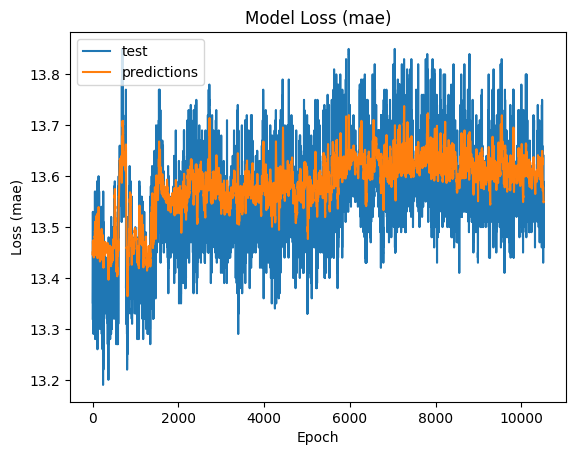

In [26]:
# comparison graph 
plt.plot(test_data)
plt.plot(forecast)
plt.title('Model Loss (mae)')
plt.ylabel('Loss (mae)')
plt.xlabel('Epoch')
plt.legend(['test', 'predictions'], loc='upper left')
plt.show()